In [ ]:
#============================================================================
# plot_cloud_stats_ceil_only_layers.ipynb
#
# Plots cloud statistics for ceil-only layers.
#
# Author: McKenna W. Stanford
#============================================================================

In [3]:
#==================================================
# Imports
#==================================================
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray
import datetime
import calendar
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import matplotlib
import pickle
import pandas as pd
import os
from file_struct import file_struct as fs
from load_sonde_data import load_sonde_data
from give_me_files_and_subfolders import give_me_files_and_subfolders
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.interpolate import NearestNDInterpolator as nn
from matplotlib.patches import Rectangle
from matplotlib import cm
import matplotlib.ticker as ticker
from scipy import stats
import matplotlib.patches as mpatches
from dask.distributed import Client, progress, LocalCluster
import time
import ctypes
#from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
#                                                  mark_inset)
import seaborn as sns
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

In [4]:
#--------------------------------------------
# Functions 
#--------------------------------------------

#--------------------------------------------
# Occurrence Frequency
#--------------------------------------------
def occur_freq(data,bins,full_length):
    tmp_hist = []
    for ii in range(len(bins)-1):
        if ii != (len(bins)-2):
            tmpid = np.where((data >= bins[ii]) & (data < bins[ii+1]))
            tmp_hist.append(np.size(tmpid)/full_length)
        elif ii == (len(bins)-2):
            tmpid = np.where((data >= bins[ii]) & (data <= bins[ii+1]))
            tmp_hist.append(np.size(tmpid)/full_length)            
    tmp_hist = np.array(tmp_hist)
    return tmp_hist,bins
#--------------------------------------------
# Trim Memory
#--------------------------------------------
def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)
#--------------------------------------------
# Find Nearest
#--------------------------------------------
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

In [5]:
path = '/mnt/raid/mwstanfo/micre/'
infile = path+'micre_cloud_properties_dict_all_vb.p'
var_dict_cloud = pickle.load(open(infile,"rb"))

In [27]:
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
# Modify precipitation occurrence frequency for Ze,thresh > -36.
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
if False:
    ze_thresh = -36.
    tmp_precip_binary = var_dict_cloud['precip_binary']
    tmp_precip_to_sfc_binary = var_dict_cloud['precip_to_sfc_binary']
    tmp_sfc_precip_binary = var_dict_cloud['sfc_precip_binary']
    tmp_ref_mean_bel = var_dict_cloud['ref_mean_bel']
    tmp_sfc_ref_mean = var_dict_cloud['sfc_ref_mean']
    tmp_rcb = var_dict_cloud['rcb']
    tmp_precip_binary_2 = tmp_precip_binary.copy()
    tmp_sfc_precip_binary_2 = tmp_sfc_precip_binary.copy()
    tmp_rcb_2 = tmp_rcb.copy()

    ref_id = np.where(tmp_ref_mean_bel >= ze_thresh)
    tmp_precip_binary_2[ref_id] = 1.
    tmp_rcb_2[ref_id] = tmp_rcb[ref_id]
    no_ref_id = np.where((tmp_ref_mean_bel < ze_thresh) & (tmp_ref_mean_bel > -999.))
    tmp_precip_binary_2[no_ref_id] = 0.
    tmp_precip_to_sfc_binary[no_ref_id] = -999.
    tmp_rcb_2[no_ref_id] = -999.

    sfc_ref_id = np.where(tmp_sfc_ref_mean >= ze_thresh)
    tmp_sfc_precip_binary_2[sfc_ref_id] = 1.
    no_sfc_ref_id = np.where((tmp_sfc_ref_mean < ze_thresh) & (tmp_sfc_ref_mean > -999.))
    tmp_sfc_precip_binary_2[no_sfc_ref_id] = 0.

    var_dict_cloud['precip_binary'] = tmp_precip_binary_2
    var_dict_cloud['sfc_precip_binary'] = tmp_sfc_precip_binary_2
    var_dict_cloud['precip_to_sfc_binary'] = tmp_precip_to_sfc_binary
    var_dict_cloud['rcb'] = tmp_rcb_2

In [28]:
var_dict_cloud.keys()

dict_keys(['time_dt', 'ctt', 'cbt', 'cth', 'cbh', 'c_thick', 'precip_binary', 'cloud_binary', 'cbh_bel_min_binary', 'bad_radar_data_flag', 'ref_mean_bel', 'vel_min_bel', 'temperature_mean_bel', 'Z_min_mean_bel', 'precip_to_sfc_binary', 'virga_binary', 'virga_base_height', 'ref_grad_above', 'ref_grad_below', 'ref_through_100m_above_binary', 'ref_through_100m_below_binary', 'IWflx', 'LWflx', 'rcb', 'ref_above_cbh_binary', 'ref_below_cbh_binary', 'precip_updraft_binary', 'sfc_precip_binary', 'sfc_precip_updraft_binary', 'sfc_IWflx', 'sfc_LWflx', 'sfc_rcb', 'sfc_ref_mean', 'sfc_vel_min', 'sfc_temperature_mean', 'num_ref_cloud_layers_in_profile', 'num_ceil_cbh_in_profile', 'nearest_ref_above_cbh', 'nearest_ref_below_cbh', 'cluster_id', 'single_layer_binary', 'ref_at_cbh_binary', 'ref_within_100m_above_cbh_binary', 'ref_within_100m_below_cbh_binary', 'cloud_50m_thick_binary', 'ceil_detection_status', 'sfc_ref_grad', 'sfc_ref_through_100m_binary', 'sfc_cloud_binary', 'fog_mask', 'fog_mask_2',

In [6]:
precip_binary = var_dict_cloud['precip_binary']
ctt = var_dict_cloud['ctt']
cbt = var_dict_cloud['cbt']
c_thick = var_dict_cloud['c_thick']
cbh = var_dict_cloud['cbh']
cth = var_dict_cloud['cth']
ref_at_cbh_binary = var_dict_cloud['ref_at_cbh_binary']
ref_within_100m_above_cbh_binary = var_dict_cloud['ref_within_100m_above_cbh_binary']
cloud_binary = var_dict_cloud['cloud_binary']
bad_radar_data_flag = var_dict_cloud['bad_radar_data_flag']

In [8]:
print(np.unique(cloud_binary))
print(np.unique(precip_binary))
print(np.unique(ref_at_cbh_binary))
print(np.unique(ref_within_100m_above_cbh_binary))
print(np.unique(bad_radar_data_flag))
print(np.min(ctt))
print(np.min(cbt))
print(np.min(cbh))
print(np.max(cbh))

[1.]
[0. 1.]
[ 0.  1. nan]
[-999.    0.    1.]
[0.]
-37.999956759932985
-37.99775416381317
262.5
7537.5


In [9]:
dumid = np.where( (~np.isnan(ref_at_cbh_binary)) & (ref_at_cbh_binary > -999.) )
ctt = ctt[dumid]
cbt = cbt[dumid]
c_thick = c_thick[dumid]
cbh = cbh[dumid]
cth = cth[dumid]
ref_at_cbh_binary = ref_at_cbh_binary[dumid]
ref_within_100m_above_cbh_binary = ref_within_100m_above_cbh_binary[dumid]

In [10]:
print(np.unique(ref_at_cbh_binary))
print(np.unique(ref_within_100m_above_cbh_binary))

[0. 1.]
[-999.    0.    1.]


In [11]:
no_ref_at_cbh_id = np.where(ref_at_cbh_binary == 0.)
print(np.size(no_ref_at_cbh_id)/np.size(ref_at_cbh_binary)*100.)

ref_at_cbh_id = np.where(ref_at_cbh_binary == 1.)
print(np.size(ref_at_cbh_id)/np.size(ref_at_cbh_binary)*100.)

nanid = np.where(np.isnan(ref_at_cbh_binary))
print(np.size(nanid)/np.size(ref_at_cbh_binary)*100.)

27.455000244374155
72.54499975562584
0.0


In [12]:
no_ref_above_id = np.where(ref_within_100m_above_cbh_binary == 0.)
print(np.size(no_ref_above_id)/np.size(ref_within_100m_above_cbh_binary)*100.)

# So, 5% of total clouds had no reflectivity at cloud base but reflectivity within 100 m above cloud base
ref_above_id = np.where(ref_within_100m_above_cbh_binary == 1.)
print(np.size(ref_above_id)/np.size(ref_within_100m_above_cbh_binary)*100.)

# % of profiles w/ reflectivity above cloud base but no reflectivity at cloud base
print(np.size(ref_above_id)/np.size(no_ref_at_cbh_id)*100.)

# Should match % of points with reflectivity at cloud base (72.48%)
dumid = np.where(ref_within_100m_above_cbh_binary == -999.)
print(np.size(dumid)/np.size(ref_within_100m_above_cbh_binary)*100.)

22.001179978076145
5.453820266298011
19.86457919415084
72.54499975562584


In [18]:
sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'lavender','axes.edgecolor': 'black'})
sns.set_context('talk')

dumid = np.where((cbt > -38.) & (cbh > 250.) & (ctt > -38.))
tmp_ref_at_cbh_binary = ref_at_cbh_binary[dumid]
tmp_cbt = cbt[dumid]
tmp_cbh = cbh[dumid]


no_ref_id = np.where(tmp_ref_at_cbh_binary == 0.)
no_ref_cbt = tmp_cbt[no_ref_id]
no_ref_cbh = tmp_cbh[no_ref_id]
levels = np.array([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,\
                   0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10])
fig = plt.figure(figsize=(12,12))
gs=GridSpec(8,8) # 6 rows, 6 columns

ax = fig.add_subplot(gs[0:6,2:8])
ax2 = fig.add_subplot(gs[0:6,0:2])
ax3 = fig.add_subplot(gs[6:8,2:8])

Fontsize=16
x = no_ref_cbt
y = no_ref_cbh*1.e-3
dum_cbh_bins = np.arange(0,8200,200)*1.e-3
bins2 = dum_cbh_bins
dum_cbt_bins = np.arange(-40,22,2)
bins1 = dum_cbt_bins
data , x_e, y_e = np.histogram2d(x, y,bins=[bins1,bins2], density = False)
data = data/np.size(no_ref_cbh)*100.
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
z[z < 0.] = 0.
#To be sure to plot all data
z[np.where(np.isnan(z))] = 0.0

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
dum_cmap = 'inferno'

x, y, z = x[idx], y[idx], z[idx]
dum=ax.scatter( x, y, c=z,cmap=dum_cmap)
cbar_ax = fig.add_axes([0.925,0.33,0.03,0.55])

#norm = Normalize(vmin = np.min(z), vmax = np.max(z))
#cbar = matplotlib.colorbar.ColorbarBase(cbar_ax,cmap=dum_cmap,norm=norm,\
#                                  spacing='uniform',\
#                                  orientation='vertical')

#cbar.ax.set_yticks([1.e-6,2.e-5,4.e-5,6.e-5,8.e-5,1.e-4])
#dumlabels=['10$^{-6}$','2x10$^{-5}$','4x10$^{-5}$','6x10$^{-5}$','8x10$^{-5}$','10$^{-4}$']
#cbar.ax.set_yticklabels(dumlabels)

nipy = cm.get_cmap('inferno',len(levels))
#bounds = levels
#norm = matplotlib.colors.BoundaryNorm(bounds,nipy.N)
norm = Normalize(vmin = np.min(z), vmax = np.max(z))
cbar = matplotlib.colorbar.ColorbarBase(cbar_ax,cmap=nipy,norm=norm,\
                                  spacing='uniform',\
                                  orientation='vertical')
cbar.ax.set_ylabel('Observation Density [%]',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)

ax.tick_params(labelsize=Fontsize)
ax.set_xlabel('CBT [$^{\\circ}$C]',fontsize=Fontsize)
ax.set_ylabel('CBH [km]',fontsize=Fontsize)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax3.yaxis.tick_left()
ax3.xaxis.tick_top()

dumxlim=ax.get_xlim()
dumylim=ax.get_ylim()
ax2.set_ylim(dumylim)
ax3.set_xlim(dumxlim)
ax2.yaxis.set_ticklabels([])
ax3.xaxis.set_ticklabels([])

ax2.set_xlabel('Observation\nDensity [%]',fontsize=Fontsize)
ax3.set_ylabel('Observation\nDensity [%]',fontsize=Fontsize)
ax2.xaxis.set_label_position('top') 

cbh_hist,cbh_bin_edges = np.histogram(no_ref_cbh*1.e-3,bins=dum_cbh_bins,density=False)
cbt_hist,cbh_bin_edges = np.histogram(no_ref_cbt,bins=dum_cbt_bins,density=False)
cbh_hist = cbh_hist/np.size(no_ref_cbh)*100.
cbt_hist = cbt_hist/np.size(no_ref_cbt)*100.
dum_cbh_midbins = np.array([(dum_cbh_bins[dd]+dum_cbh_bins[dd+1])/2. for dd in range(len(dum_cbh_bins)-1)])
dum_cbt_midbins = np.array([(dum_cbt_bins[dd]+dum_cbt_bins[dd+1])/2. for dd in range(len(dum_cbt_bins)-1)])

ax2.barh(dum_cbh_midbins,cbh_hist,color='royalblue',height=0.175)
ax3.bar(dum_cbt_midbins,cbt_hist,color='royalblue',width=1.75)
ax2.set_xlim(20,0)
ax3.set_ylim(20,0)

med_cbh = np.median(no_ref_cbh)*1.e-3
med_cbt = np.median(no_ref_cbt)

dumstr = 'Median CBH'
ax2.text(0.03,0.9,dumstr,c='royalblue',fontsize=Fontsize,transform=ax2.transAxes,fontweight='bold')
ax2.plot([0.03,0.95],[0.89,0.89],lw=2,c='royalblue',transform=ax2.transAxes)
dumstr = str(np.around(med_cbh,2))+' km'
ax2.text(0.03,0.85,dumstr,c='royalblue',fontsize=Fontsize,transform=ax2.transAxes,fontweight='bold')

dumstr = 'Frac. < 2 km'
ax2.text(0.03,0.8,dumstr,c='royalblue',fontsize=Fontsize,transform=ax2.transAxes,fontweight='bold')
ax2.plot([0.03,0.95],[0.79,0.79],lw=2,c='royalblue',transform=ax2.transAxes)
cbh_frac_lt_2km = np.size(np.where((no_ref_cbh*1.e-3) < 2.))/np.size(no_ref_cbh)
dumstr = str(np.around(cbh_frac_lt_2km,2))
ax2.text(0.03,0.75,dumstr,c='royalblue',fontsize=Fontsize,transform=ax2.transAxes,fontweight='bold')

dumstr = 'Median CBT'
ax3.text(0.03,0.8,dumstr,c='royalblue',fontsize=Fontsize,transform=ax3.transAxes,fontweight='bold')
ax3.plot([0.03,0.25],[0.75,0.75],lw=2,c='royalblue',transform=ax3.transAxes)
dumstr = str(np.around(med_cbt,0))+'$^{\\circ}$C'
ax3.text(0.03,0.6,dumstr,c='royalblue',fontsize=Fontsize,transform=ax3.transAxes,fontweight='bold')

dumstr = 'Frac. < 0$^{\\circ}$C'
ax3.text(0.03,0.4,dumstr,c='royalblue',fontsize=Fontsize,transform=ax3.transAxes,fontweight='bold')
ax3.plot([0.03,0.25],[0.35,0.35],lw=2,c='royalblue',transform=ax3.transAxes)
cbt_frac_lt_0degC = np.size(np.where(no_ref_cbt < 0))/np.size(no_ref_cbt)
dumstr = str(np.around(cbt_frac_lt_0degC,2))
ax3.text(0.03,0.2,dumstr,c='royalblue',fontsize=Fontsize,transform=ax3.transAxes,fontweight='bold')



dumstr1 = '% of Dataset: '
size1 = np.size(no_ref_cbh)
size2 = np.size(np.where( (cbt > -38.) & (cbh > -999.)))
dum_perc = size1/size2*100.
dumstr2 = dumstr1+str(np.around(dum_perc,0))[0:2]
ax.text(0.4,0.925,dumstr2,transform=ax.transAxes,fontsize=Fontsize*1.55,fontweight='bold')
ax.text(0.5,1.05,'CEIL-only Cloud Layers',fontsize=Fontsize*2.,transform=ax.transAxes,ha='center')
plt.subplots_adjust(wspace=2,hspace=2)
fig_path = '/home/mwstanfo/figures/micre_paper/'
outfile = 'fig_07.png'
#outfile = 'fig_09.eps'
plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')  
#plt.show()
plt.close()
print('done')

done


<BarContainer object of 40 artists>

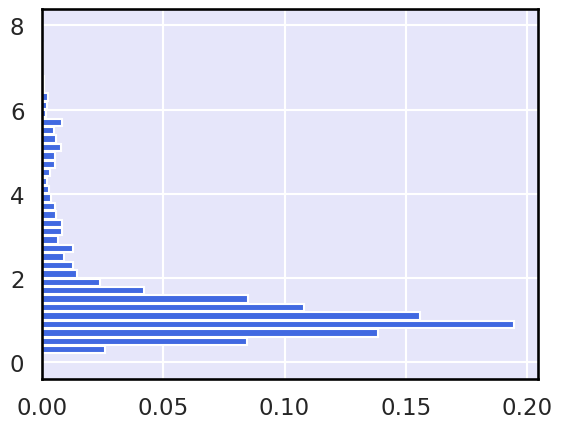

In [27]:
cbh_hist,cbh_bin_edges = np.histogram(no_ref_cbh*1.e-3,bins=dum_cbh_bins,density=False)
cbt_hist,cbh_bin_edges = np.histogram(no_ref_cbt,bins=dum_cbt_bins,density=False)
cbh_hist = cbh_hist/np.size(no_ref_cbh)
cbt_hist = cbt_hist/np.size(no_ref_cbt)
dum_cbh_midbins = np.array([(dum_cbh_bins[dd]+dum_cbh_bins[dd+1])/2. for dd in range(len(dum_cbh_bins)-1)])
dum_cbt_midbins = np.array([(dum_cbt_bins[dd]+dum_cbt_bins[dd+1])/2. for dd in range(len(dum_cbt_bins)-1)])
plt.barh(dum_cbh_midbins,cbh_hist,color='royalblue',height=0.175)

In [ ]:
#---------------------------------------------------------
#---------------------------------------------------------
# Joint Histogram of No Ref CBT and cbH
#---------------------------------------------------------
#---------------------------------------------------------
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

cbh_bins = np.arange(0,12500,500)*1.e-3
cbt_bins = np.arange(-50,24,4)

var1 = no_ref_cbt.copy()
var2 = no_ref_cbh.copy()*1.e-3


var1_bins = cbt_bins
var2_bins = cbh_bins
var1_binsize = var1_bins[1]-var1_bins[0]
var2_binsize = var2_bins[1]-var2_bins[0]

var1_midbins = np.array([(var1_bins[ii] + var1_bins[ii+1])/2 for ii in range(len(var1_bins)-1)])     
var2_midbins = np.array([(var2_bins[ii] + var2_bins[ii+1])/2 for ii in range(len(var2_bins)-1)])  

# Joint histogram of CBT and Cloud Depth Precipitating Fraction
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)
Fontsize=18
ax1.set_xlabel('CBT [$^{\\circ}$C]',fontsize=Fontsize)
ax1.set_ylabel('CBH [km]',fontsize=Fontsize)
ax1.tick_params(labelsize=Fontsize)


levels = np.array([0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,\
                   0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,\
                   0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

nipy = cm.get_cmap('inferno',len(levels))
newcolors = nipy(np.linspace(0,1,len(levels)))   
numvec = np.zeros((len(var1_bins)-1,len(var2_bins)-1))

perc = np.zeros((len(var1_bins),len(var2_bins)))
for ii in range(len(var1_bins)-1):
    
    for jj in range(len(var2_bins)-1):
        
        dumvar1 = var1.copy()
        dumvar2 = var2.copy()

        tmpid = np.where( (dumvar1 >= var1_bins[ii]) & (dumvar1 < var1_bins[ii+1]) & (dumvar2 >= var2_bins[jj]) & (dumvar2 < var2_bins[jj+1]))
        dumperc = np.size(tmpid)/np.size(dumvar1)*100.
        perc[ii,jj] = dumperc
        if dumperc > 0.001:
            var1_lim = dumvar1[tmpid]
            var2_lim = dumvar2[tmpid]
            #mean_y_var[jj] = np.nanmean(var2_lim)  
            
            col = np.max(np.where(dumperc >= levels))
            tmpplot = ax1.add_patch(Rectangle((var1_bins[ii],var2_bins[jj]),\
                                        var1_binsize,var2_binsize,\
                                        alpha=1,edgecolor=None,\
                                        facecolor=newcolors[col]))
        else:
            #mean_y_var[jj] = np.nan
            tmpplot = ax1.add_patch(Rectangle((var1_bins[ii],var2_bins[jj]),\
                                    var1_binsize,var2_binsize,\
                                    alpha=1,edgecolor=None,\
                                   facecolor='black'))       



ax1.set_xlim(var1_bins[0],var1_bins[-1])
ax1.set_ylim(var2_bins[0],var2_bins[-1])

bounds = levels
norm = matplotlib.colors.BoundaryNorm(bounds,nipy.N)
ax99 = fig.add_axes([0.925,0.12,0.03,0.765])
cb = matplotlib.colorbar.ColorbarBase(ax99,cmap=nipy,norm=norm,\
                                  spacing='uniform',\
                                  ticks=bounds,\
                                  boundaries=bounds,
                                  orientation='vertical')
cb.set_ticks([0.001,0.01,0.1,1])
cb.set_ticklabels(['10$^{-3}$','10$^{-2}$','10$^{-1}$','1'])

ax99.tick_params(labelsize=Fontsize)
ax99.set_ylabel('Observation Density [%]',fontsize=Fontsize)

ax1.grid(False)
plt.show()
plt.close()       